## Reading scRNA-seq data into R

v1.0 (2021-03-26)  
Lucas Graybuck  

### Purpose

In this notebook, we'll see how the scRNA-seq .h5 files downlaoded from HISE can be read into R for use with packages like `Seurat` and the `BioConductor` suite.

This notebook was generated using the `R` language, running in the Jupyter Notebook environment on a HISE IDE instance. See the end of the document for the [Session Info](#Session-Info) for additional software version details.

<a name = "contents"></a>

### Contents

- [Importing packages](#Importing-packages)
- [Using h5 helper functions](#Using-h5-helper-functions)
    - [Import for Seurat](#Import-for-Seurat)
    - [Import for BioConductor](#Import-for-BioConductor)
- [Basic demo with Seurat](#Basic-demo-with-Seurat)
- [Reading data components](#Reading-data-components)
    - [Matrices](#Matrices)
    - [Metadata](#Metadata)
- [Session Info](#Session-Info)

### Importing packages

To work with scRNA-seq data, we'll first load a few packages:
- `H5weaver`: For reading .h5 files downloaded from HISE
- `Seurat`: For basic scRNA-seq analysis
- `SingleCellExperiment`: Import for use with BioConductor packages

Because some of these packages dump a lot of messages to the console, we'll bypass these using this helper function, `quiet_library()`:

In [1]:
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}

In [2]:
quiet_library(H5weaver)
quiet_library(Seurat)
quiet_library(SingleCellExperiment)

### Using h5 helper functions

To get started quickly, the `H5weaver` package includes multiple helper functions to read .h5's directly in for popular R analysis packages.

#### Import for Seurat

For use with Seurat, we can build a SeuratObject direclty with the `read_h5_seurat()` function.

By default, this uses ENSEMBL IDs to identify genes. For ease of use, we may want to use symbols, which can be set by specifying `feature_names = "name"`.

In [3]:
so <- read_h5_seurat('cache/58687b56-b0d6-4d0b-a46e-da57f7cf4665/B017-P1_PB00134-01_2020-09-15T19:35:44.423205814Z_labeled.h5',
                     feature_names = "name")
so

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


An object of class Seurat 
33538 features across 16663 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

#### Import for BioConductor

For BioConductor packages, we also provide a quick way to generate `SingleCellExperiment` objects:

In [4]:
sce <- read_h5_sce('cache/58687b56-b0d6-4d0b-a46e-da57f7cf4665/B017-P1_PB00134-01_2020-09-15T19:35:44.423205814Z_labeled.h5')
sce

class: SingleCellExperiment 
dim: 33538 16663 
metadata(0):
assays(1): counts
rownames(33538): ENSG00000243485 ENSG00000237613 ... ENSG00000277475
  ENSG00000268674
rowData names(4): feature_type genome id name
colnames(16663): 75464f20fa4d11ea81509e49704367d9
  754650c4fa4d11ea81509e49704367d9 ... e144b3e2fa5211ea8383e6a022d3c9e0
  e144bc20fa5211ea8383e6a022d3c9e0
colData names(19): barcodes batch_id ... umap_2 well_id
reducedDimNames(0):
altExpNames(0):

### Basic demo with Seurat

Seurat provides a comprehensive toolkit for scRNA-seq analysis. Here, we'll take a quick look at basic analysis.

For more details and options, refer to the full [Seurat documentation and vignettes](https://satijalab.org/seurat/articles/get_started.html).

In [5]:
# Normalize and log-transform the count data
so <- NormalizeData(so)

# Find highly variable genes
so <- FindVariableFeatures(so)

Centering and scaling data matrix



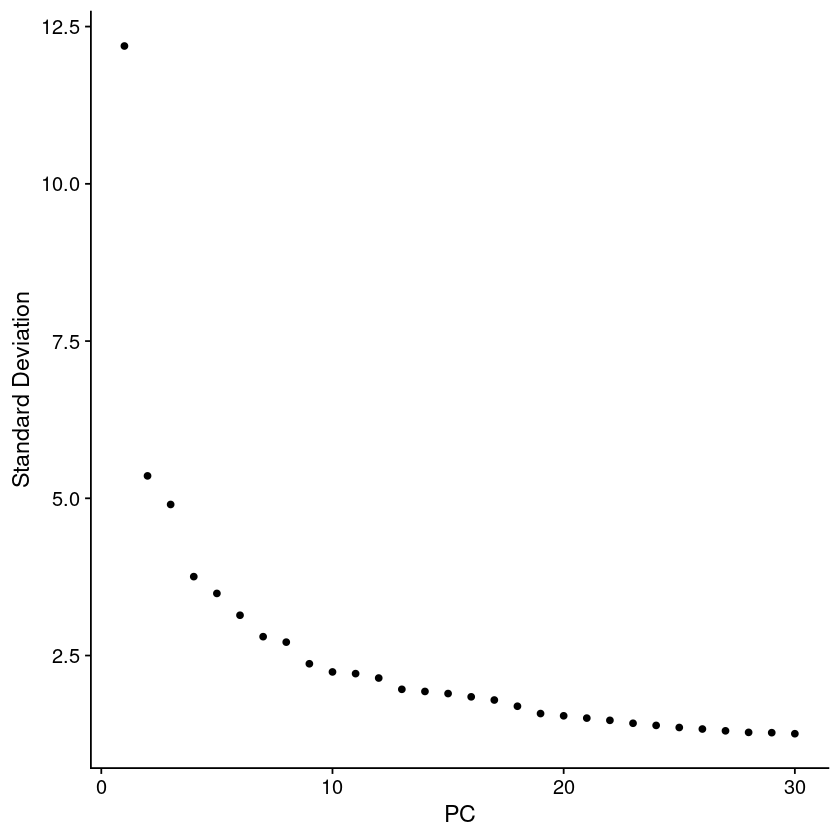

In [6]:
# Scale data
so <- ScaleData(so)

# Run PCA
so <- RunPCA(so, verbose = FALSE)

# Examine variance ratios of PCs
ElbowPlot(so, ndims = 30)

In [7]:
# Find nearest neighbors
so <- FindNeighbors(so, dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [8]:
# Run Louvain clustering
so <- FindClusters(so)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16663
Number of edges: 663254

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8884
Number of communities: 23
Elapsed time: 6 seconds


In [9]:
# Run UMAP
so <- RunUMAP(so, dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


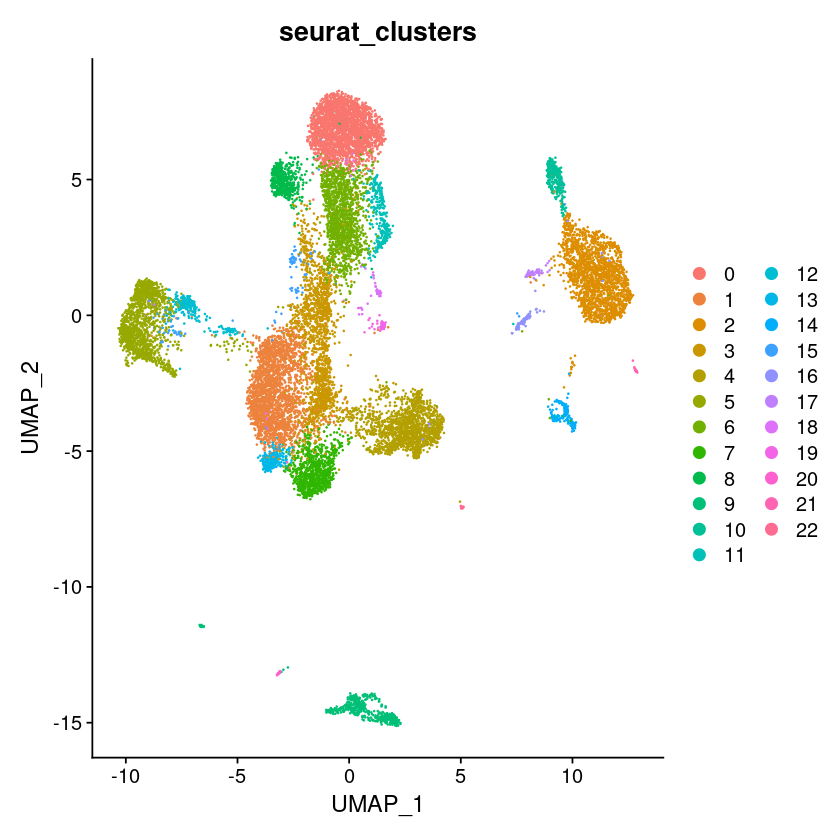

In [10]:
# Plot results
DimPlot(so, reduction = "umap", group.by = "seurat_clusters")

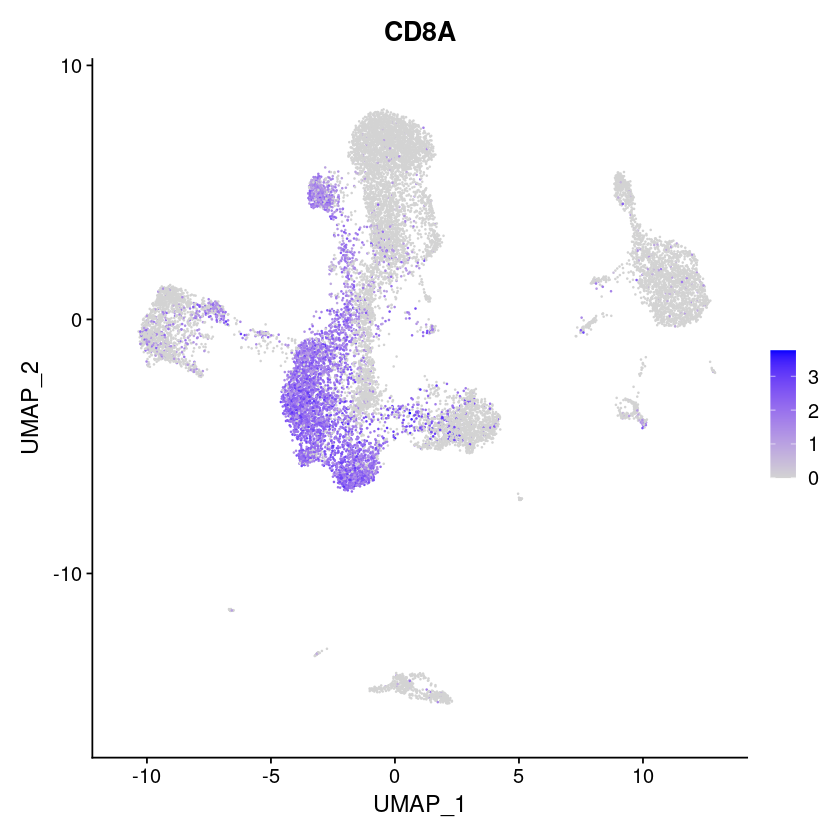

In [11]:
FeaturePlot(so, "CD8A", reduction = "umap")

### Reading data components

In addition to working with the frameworks, above, `H5weaver` provides functions to read the data and metadata into R in more generic data structures.

#### Matrices

Data matrices can be read into R as a `dgCMatrix` object. This is a commonly-used class for sparse matrices from the `Matrix` package, and is frequently used as an input for single-cell analysis.

In [12]:
mat <- read_h5_dgCMatrix('cache/58687b56-b0d6-4d0b-a46e-da57f7cf4665/B017-P1_PB00134-01_2020-09-15T19:35:44.423205814Z_labeled.h5',
                         feature_names = "name")
str(mat)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:24086066] 48 91 154 166 190 222 244 259 315 338 ...
  ..@ p       : int [1:16664] 0 1280 2152 3704 5627 8722 10227 11822 13933 15725 ...
  ..@ Dim     : int [1:2] 33538 16663
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:33538] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...
  .. ..$ : chr [1:16663] "75464f20fa4d11ea81509e49704367d9" "754650c4fa4d11ea81509e49704367d9" "75465696fa4d11ea81509e49704367d9" "754656fafa4d11ea81509e49704367d9" ...
  ..@ x       : num [1:24086066] 1 1 11 2 1 1 1 1 1 1 ...
  ..@ factors : list()


#### Metadata

Cell and feature metadata can also be read into R as base data.frames for use with many kinds of analysis:

In [13]:
cell_meta <- read_h5_cell_meta('cache/58687b56-b0d6-4d0b-a46e-da57f7cf4665/B017-P1_PB00134-01_2020-09-15T19:35:44.423205814Z_labeled.h5')
head(cell_meta)

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,n_umis,original_barcodes,pbmc_sample_id,pool_id,seurat_pbmc_type,seurat_pbmc_type_score,umap_1,umap_2,well_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,75464f20fa4d11ea81509e49704367d9,B017,unpacified_equitable_marten,75464f20fa4d11ea81509e49704367d9,B017-P1C1,TTCCGCCTCTCTTTG,singlet,1280,103,13910,4039,AAACCCAAGCTATCTG,PB00134-01,B017-P1,CD4 Naive,0.9421429,1.9137258,-7.7660392,B017-P1C1W1
2,754650c4fa4d11ea81509e49704367d9,B017,wrinkled_abased_sphinx,754650c4fa4d11ea81509e49704367d9,B017-P1C1,TTCCGCCTCTCTTTG,singlet,872,145,5565,1695,AAACCCAAGTTTGCTG,PB00134-01,B017-P1,CD8 effector,0.7223891,4.7013806,1.7509021,B017-P1C1W1
3,75465696fa4d11ea81509e49704367d9,B017,bigheaded_sad_schnauzer,75465696fa4d11ea81509e49704367d9,B017-P1C1,TTCCGCCTCTCTTTG,singlet,1552,142,14726,4356,AAACCCAGTAACTTCG,PB00134-01,B017-P1,CD8 effector,1.0000000,-0.2638944,6.4224525,B017-P1C1W1
4,754656fafa4d11ea81509e49704367d9,B017,aboriginal_heavensent_tortoise,754656fafa4d11ea81509e49704367d9,B017-P1C1,TTCCGCCTCTCTTTG,singlet,1923,97,16081,4654,AAACCCAGTAATGCTC,PB00134-01,B017-P1,NK cell,0.9984433,-0.5257674,11.0047853,B017-P1C1W1
5,75466a14fa4d11ea81509e49704367d9,B017,amethyst_anthracite_goa,75466a14fa4d11ea81509e49704367d9,B017-P1C1,TTCCGCCTCTCTTTG,singlet,3095,362,45162,13521,AAACGCTGTACAACGG,PB00134-01,B017-P1,CD14+ Monocytes,1.0000000,-9.2712083,-0.3602708,B017-P1C1W1
6,754670fefa4d11ea81509e49704367d9,B017,raspberry_baleful_egret,754670fefa4d11ea81509e49704367d9,B017-P1C1,TTCCGCCTCTCTTTG,singlet,1505,143,17268,5265,AAACGCTTCATGGGAG,PB00134-01,B017-P1,CD4 Naive,0.9991383,1.0878532,-7.0717452,B017-P1C1W1


In [14]:
feature_meta <- read_h5_feature_meta('cache/58687b56-b0d6-4d0b-a46e-da57f7cf4665/B017-P1_PB00134-01_2020-09-15T19:35:44.423205814Z_labeled.h5')
head(feature_meta)

,feature_type,genome,id,name
,<chr>,<chr>,<chr>,<chr>
1,Gene Expression,GRCh38,ENSG00000243485,MIR1302-2HG
2,Gene Expression,GRCh38,ENSG00000237613,FAM138A
3,Gene Expression,GRCh38,ENSG00000186092,OR4F5
4,Gene Expression,GRCh38,ENSG00000238009,AL627309.1
5,Gene Expression,GRCh38,ENSG00000239945,AL627309.3
6,Gene Expression,GRCh38,ENSG00000239906,AL627309.2


### Session Info

In [15]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [3] Biobase_2.50.0              GenomicRanges_1.42.0       
 [5] GenomeInfoDb_1.26.2         IRanges_2.24.1             
 [7] S4Vectors_0.28.1            BiocGenerics_0.36.0        
 [9] MatrixGenerics_1.2.1        matrixStats_0